In [1]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

# Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda", 0)
train_size=0.00108

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse  

Cuda installed! Running on GPU 0 GeForce RTX 2080 Ti!


In [3]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            if epoch < switch_at_epoch:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            else:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, awi1D, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = awi1D(recon, X)
                v, T = awi1D.v_all[0], awi1D.T_arr

                print("\n", log)
                print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())

                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)
                axs[0, 0].imshow(recon[0].permute(1,2,0).cpu().detach().numpy(), vmin=0., vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0].permute(1,2,0).cpu().detach().numpy(), vmin=0., vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0].permute(1,2,0).cpu().detach().numpy() - recon[0].permute(1,2,0).cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                axs[1, 0].plot(v.detach().cpu().numpy())
                axs[1, 0].plot(T.flatten().detach().cpu().numpy(), "--")
                axs[1, 0].set_title("T-1D vs v-1D")
                axs[1, 0].set_ylim(None, 1.1)

                axs[1, 1].plot((T.flatten() - v).detach().cpu().numpy())
                axs[1, 1].set_title("T1D - v1D")
                axs[1, 1].set_ylim(None, 1.1)
                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="aw_loss1d")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# CIFAR10 Example

## Datasets and Dataloaders

In [4]:
# Train Transforms
train_transform = Compose([
    Resize(28),
])

# Datasets and dataloaders
ds = CIFAR10("./", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = torch.from_numpy(ds.data[train_idx]) / 255., torch.tensor(ds.targets)[train_idx]
X_train = X_train.permute(0, 3, 1, 2)
trainds = TransformTensorDataset(X_train.float(), y_train.float(), transform=train_transform)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Files already downloaded and verified
Trainable Images: 54
torch.Size([1, 3, 28, 28]) 0.014325735159218311 1.0


## Autoencoder FC

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06961493194103241, 'train_awi1d_loss': 16.331512451171875, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


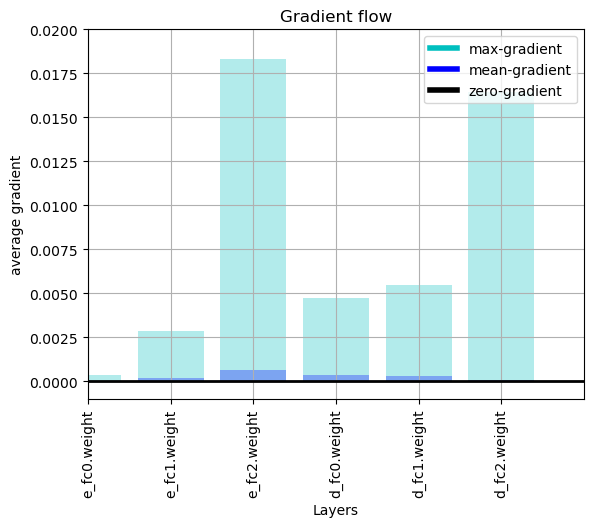

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


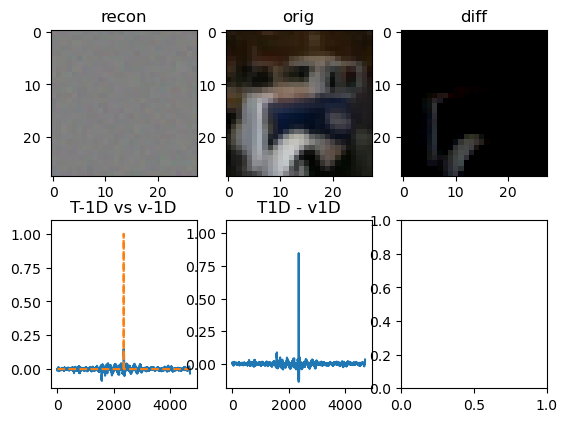

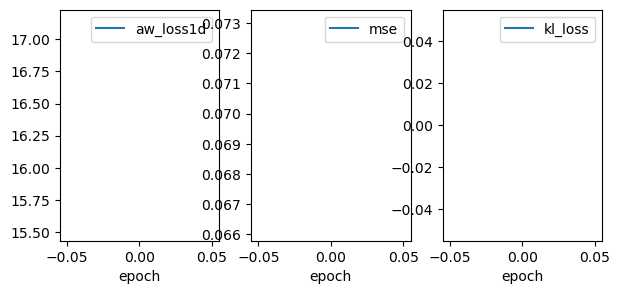

 20% (20 of 100) |####                   | Elapsed Time: 0:03:07 ETA:   0:12:26


 {'epoch': 20, 'train_mse': 0.07011718302965164, 'train_awi1d_loss': 14.33102035522461, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


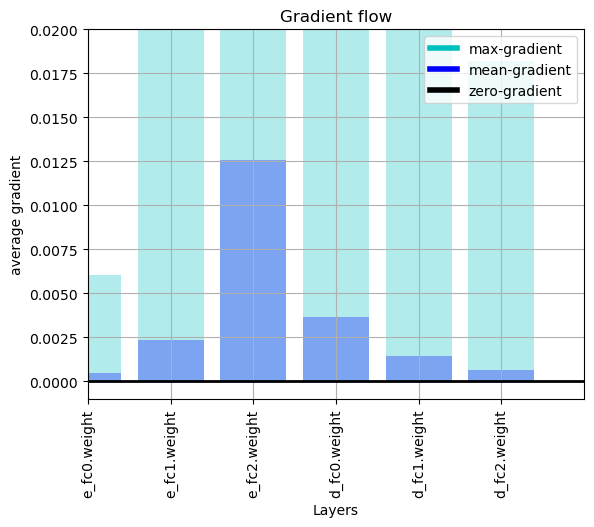

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


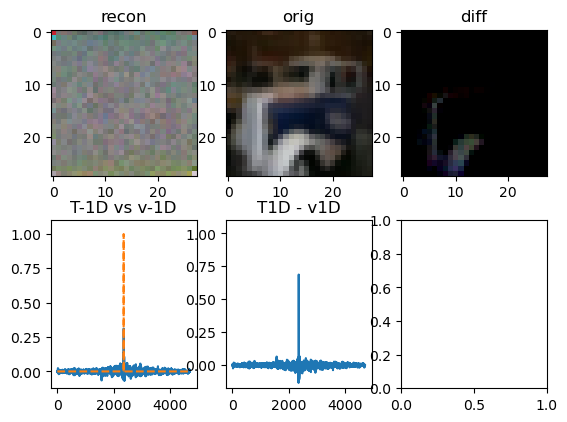

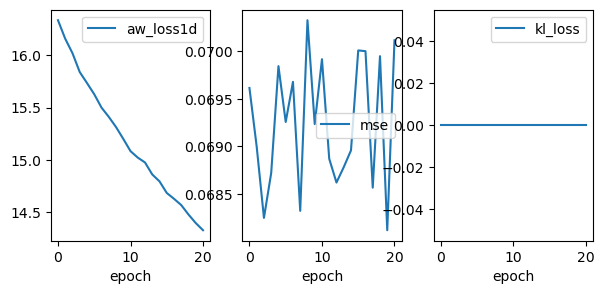

 40% (40 of 100) |#########              | Elapsed Time: 0:06:15 ETA:   0:09:20


 {'epoch': 40, 'train_mse': 0.06879466027021408, 'train_awi1d_loss': 12.907102584838867, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


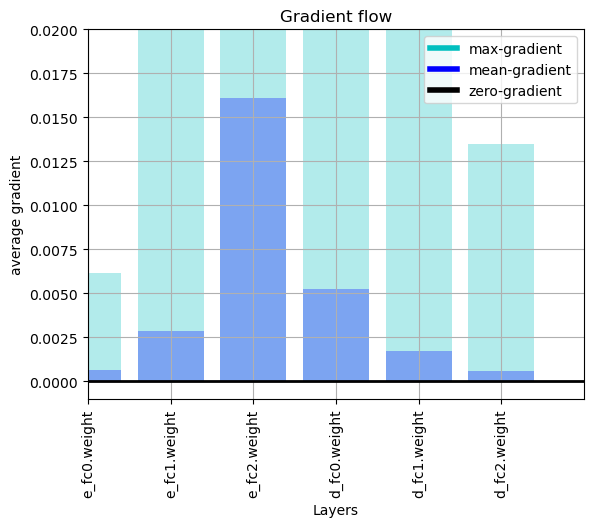

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


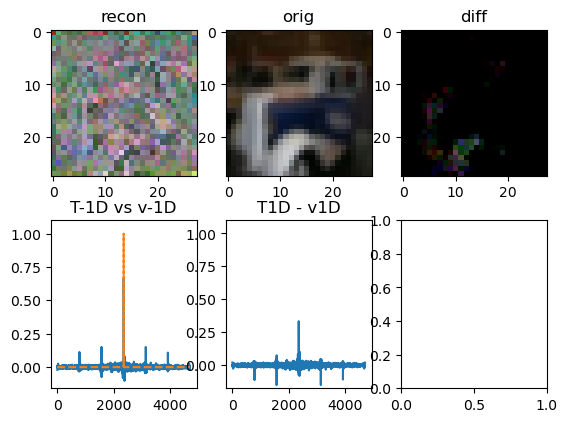

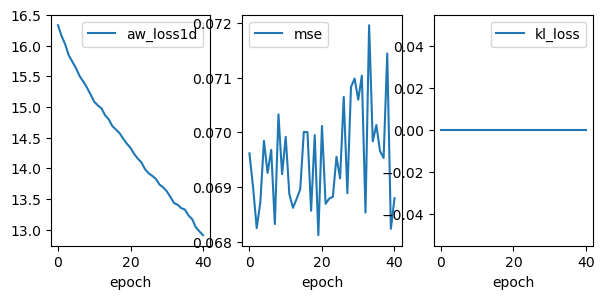

 60% (60 of 100) |#############          | Elapsed Time: 0:09:23 ETA:   0:06:14


 {'epoch': 60, 'train_mse': 0.06533712893724442, 'train_awi1d_loss': 10.723592758178711, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


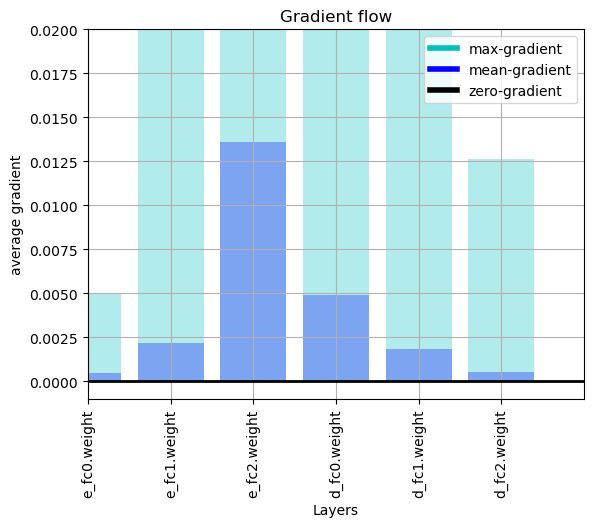

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


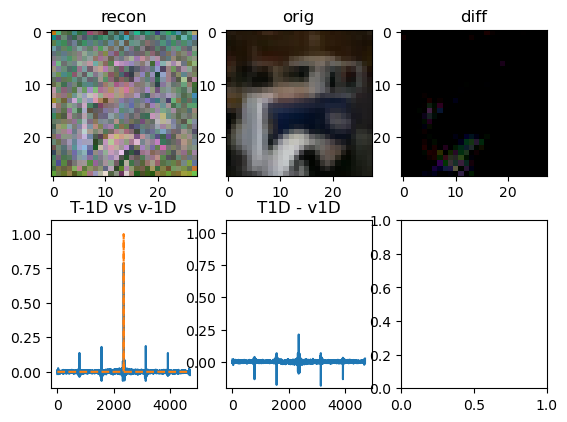

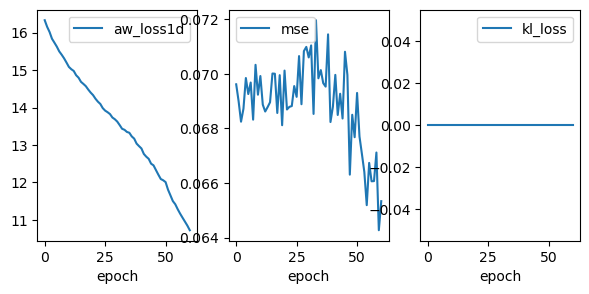

 80% (80 of 100) |##################     | Elapsed Time: 0:12:32 ETA:   0:03:08


 {'epoch': 80, 'train_mse': 0.06407294422388077, 'train_awi1d_loss': 9.44991397857666, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


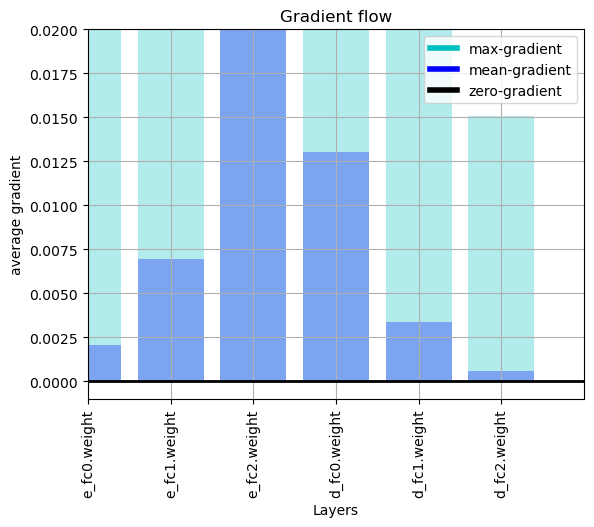

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


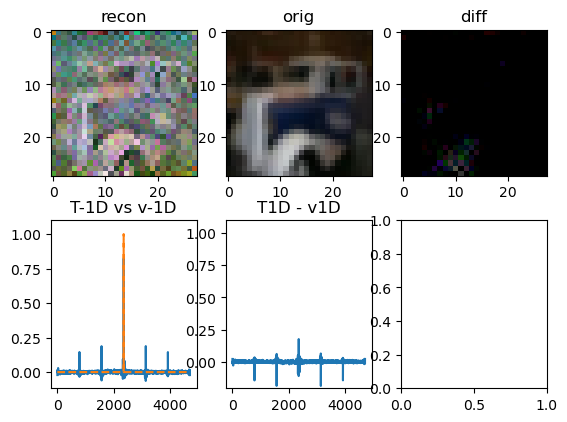

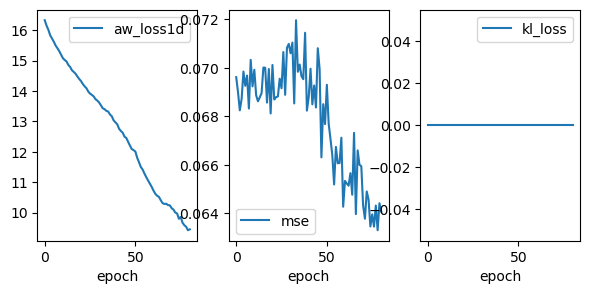

 99% (99 of 100) |###################### | Elapsed Time: 0:15:31 ETA:   0:00:09


 {'epoch': 99, 'train_mse': 0.06242816150188446, 'train_awi1d_loss': 8.478178977966309, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


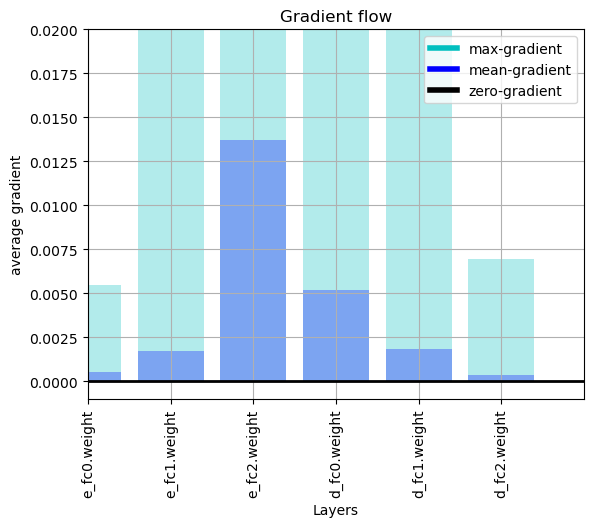

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


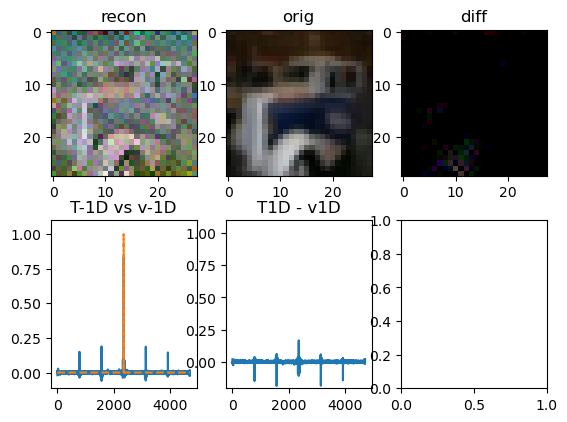

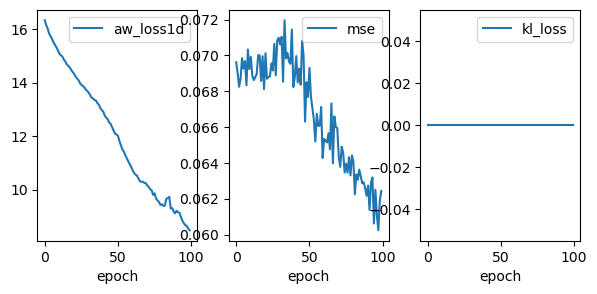

100% (100 of 100) |######################| Elapsed Time: 0:15:32 Time:  0:15:32


In [5]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Visualise Loss Landscape of Autoencoder (FC)

Train Subset len:  1
Angle between x_dir and y_dir: 90.05 °


100% (625 of 625) |######################| Elapsed Time: 0:03:43 Time:  0:03:43


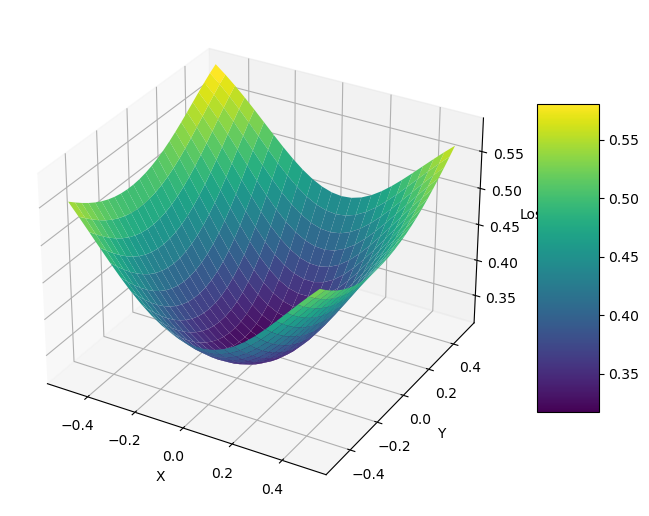

In [7]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=1)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)


## Variational Autoencoder (FC)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06811835616827011, 'train_awi1d_loss': 16.490615844726562, 'train_kl_loss': 571.6918334960938}
 argidx T, v:  2351 2351


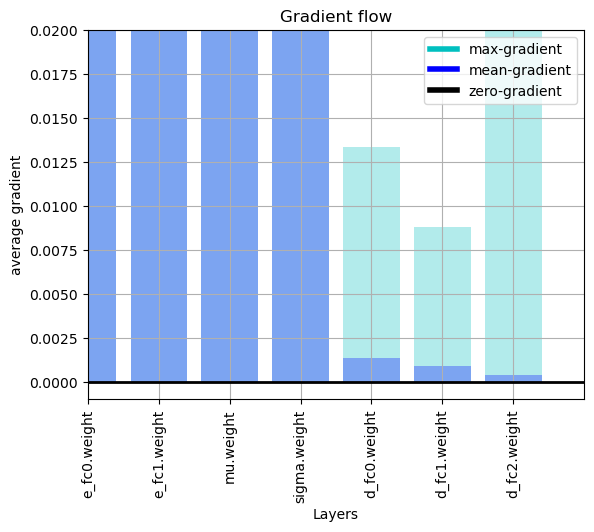

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


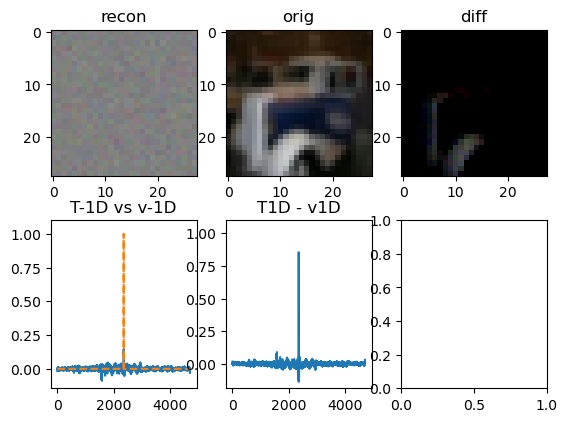

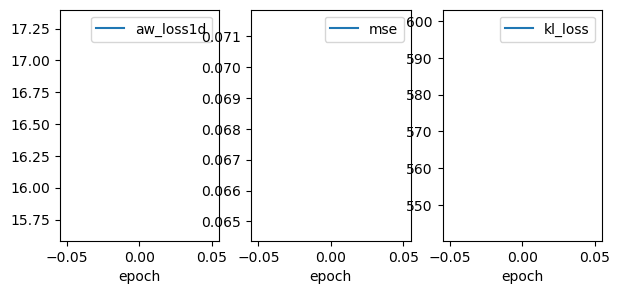

 20% (20 of 100) |####                   | Elapsed Time: 0:03:07 ETA:   0:12:25


 {'epoch': 20, 'train_mse': 0.06998920440673828, 'train_awi1d_loss': 15.498360633850098, 'train_kl_loss': 432.27630615234375}
 argidx T, v:  2351 2351


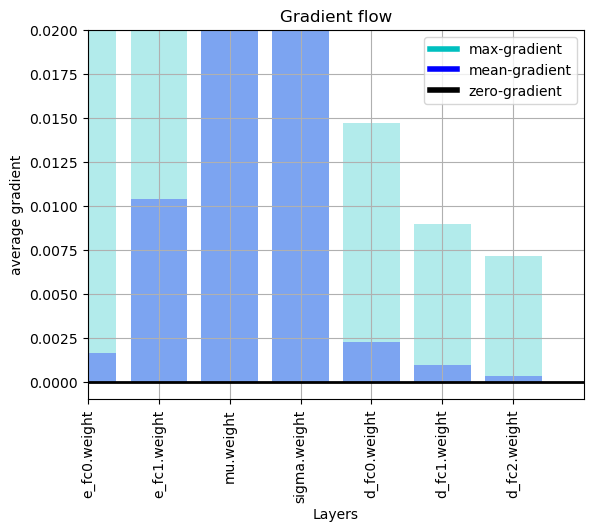

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


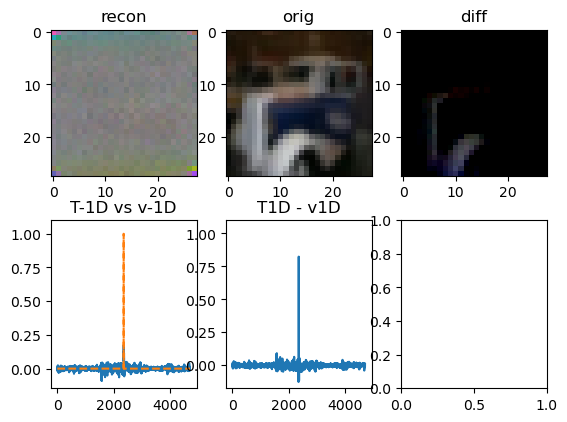

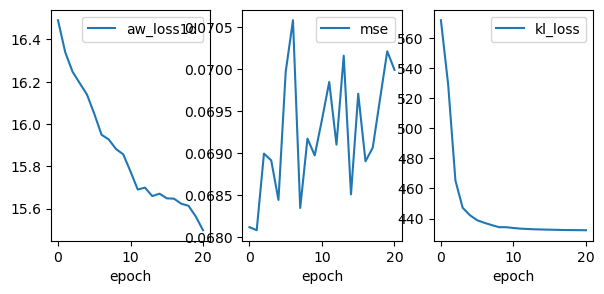

 40% (40 of 100) |#########              | Elapsed Time: 0:06:14 ETA:   0:09:21


 {'epoch': 40, 'train_mse': 0.07123613357543945, 'train_awi1d_loss': 15.329794883728027, 'train_kl_loss': 432.0446472167969}
 argidx T, v:  2351 2351


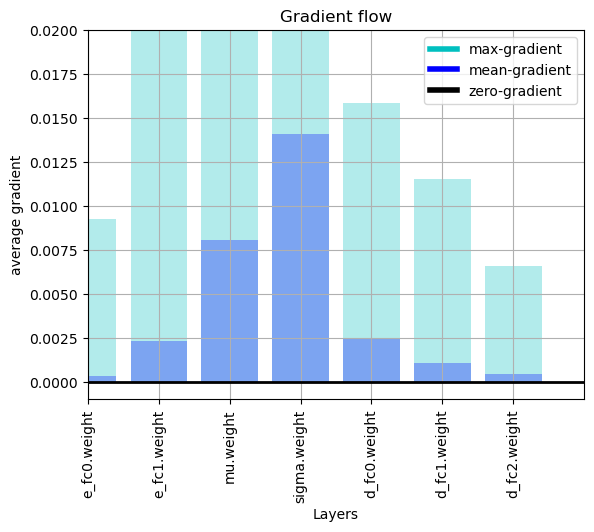

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


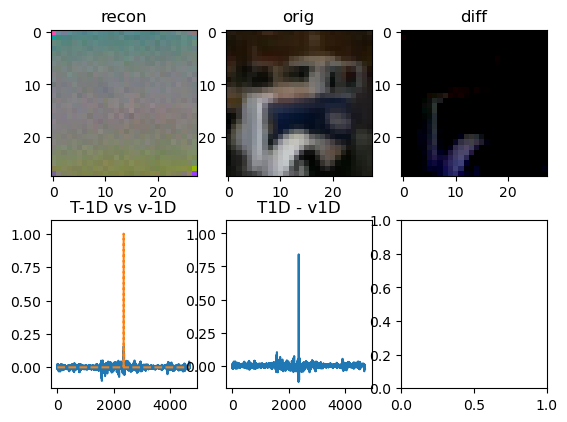

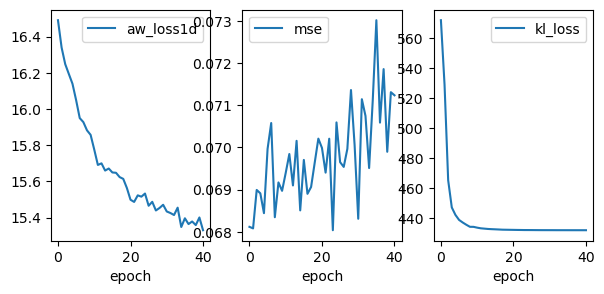

 60% (60 of 100) |#############          | Elapsed Time: 0:09:21 ETA:   0:06:13


 {'epoch': 60, 'train_mse': 0.07446654140949249, 'train_awi1d_loss': 15.320619583129883, 'train_kl_loss': 432.0250549316406}
 argidx T, v:  2351 2351


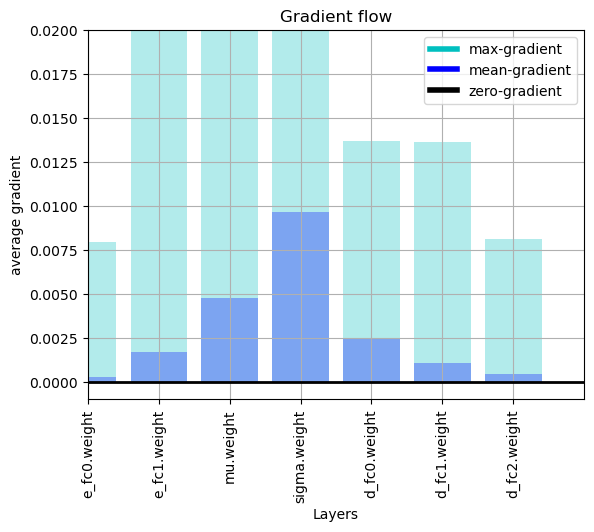

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


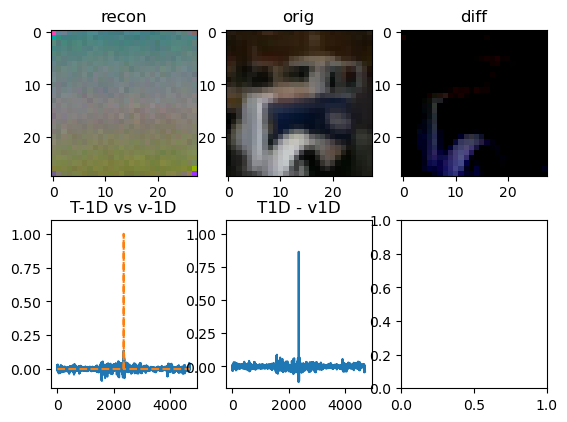

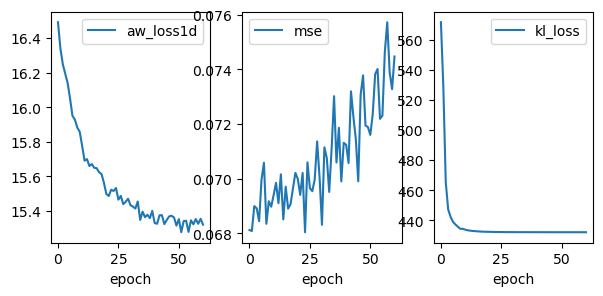

 80% (80 of 100) |##################     | Elapsed Time: 0:12:28 ETA:   0:03:06


 {'epoch': 80, 'train_mse': 0.07605989277362823, 'train_awi1d_loss': 15.293615341186523, 'train_kl_loss': 432.03985595703125}
 argidx T, v:  2351 2351


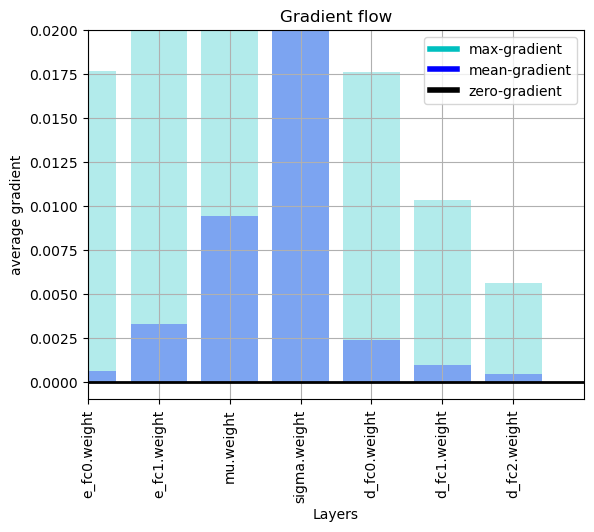

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


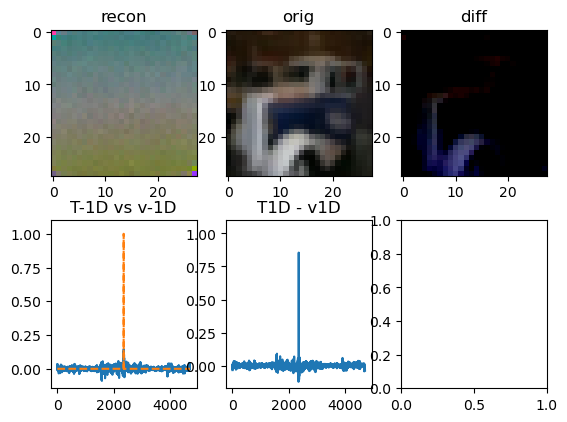

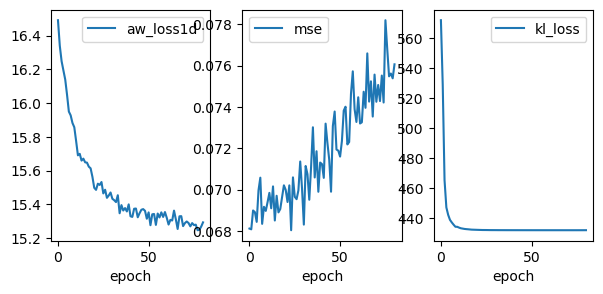

 99% (99 of 100) |###################### | Elapsed Time: 0:15:26 ETA:   0:00:09


 {'epoch': 99, 'train_mse': 0.07620270550251007, 'train_awi1d_loss': 15.199694633483887, 'train_kl_loss': 432.01373291015625}
 argidx T, v:  2351 2351


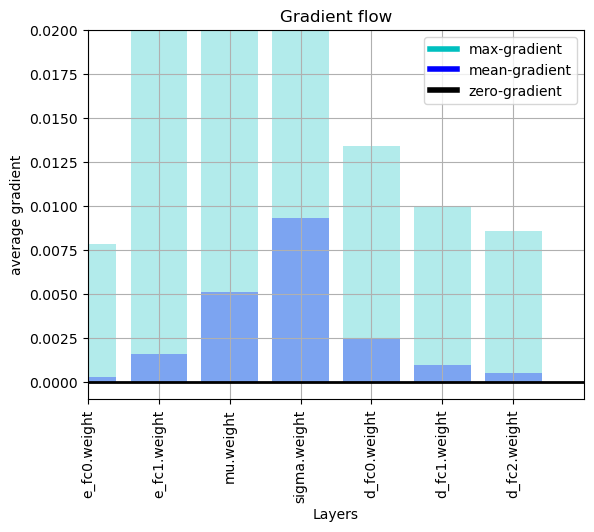

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


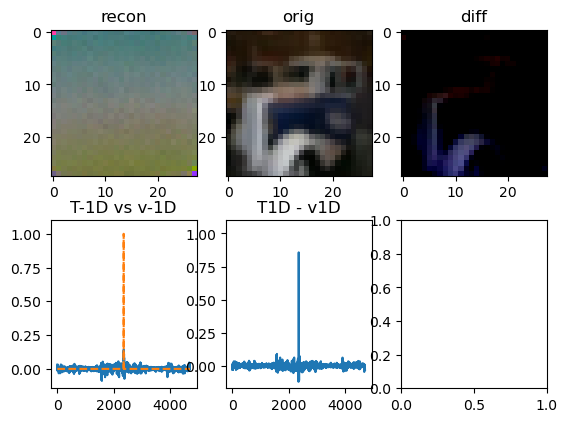

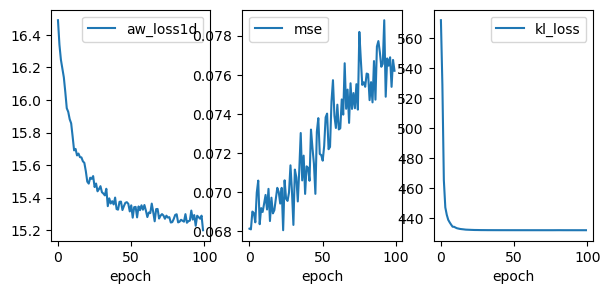

100% (100 of 100) |######################| Elapsed Time: 0:15:27 Time:  0:15:27


In [8]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06971050798892975, 'train_awi1d_loss': 16.304935455322266, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


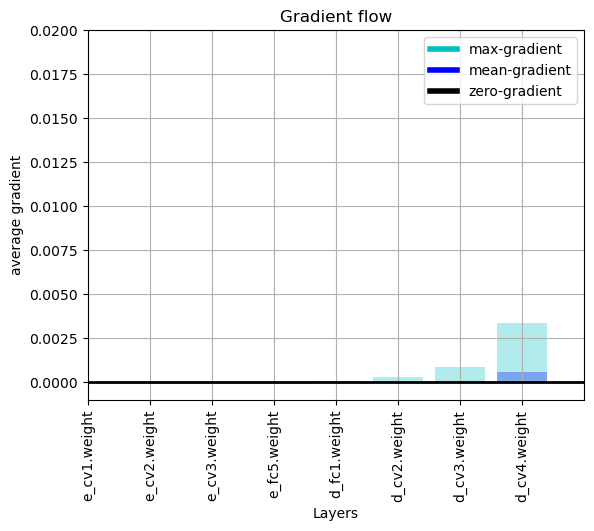

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


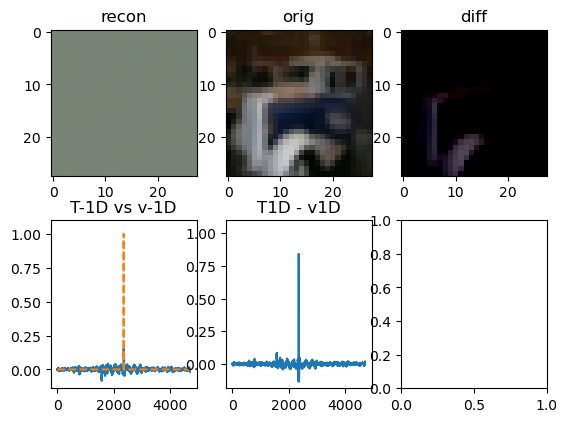

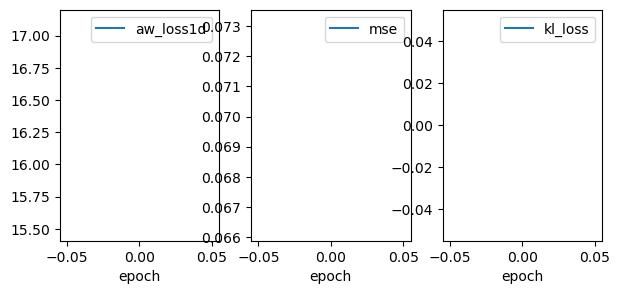

 20% (20 of 100) |####                   | Elapsed Time: 0:03:03 ETA:   0:12:14


 {'epoch': 20, 'train_mse': 0.07291367650032043, 'train_awi1d_loss': 15.43171215057373, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


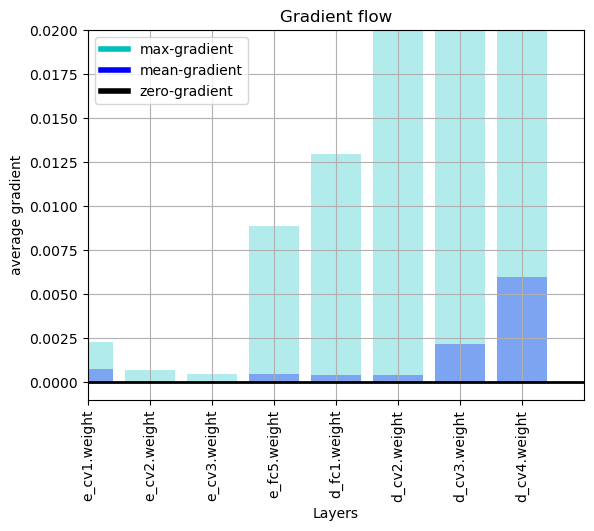

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


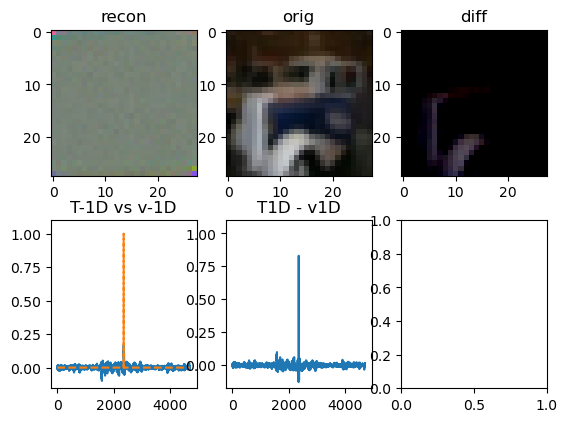

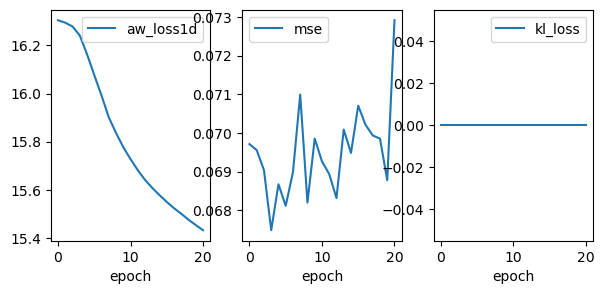

 40% (40 of 100) |#########              | Elapsed Time: 0:06:08 ETA:   0:09:10


 {'epoch': 40, 'train_mse': 0.0724463015794754, 'train_awi1d_loss': 15.008037567138672, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


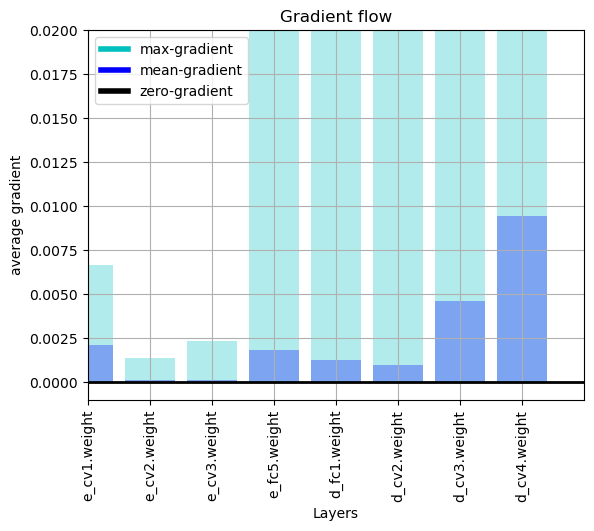

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


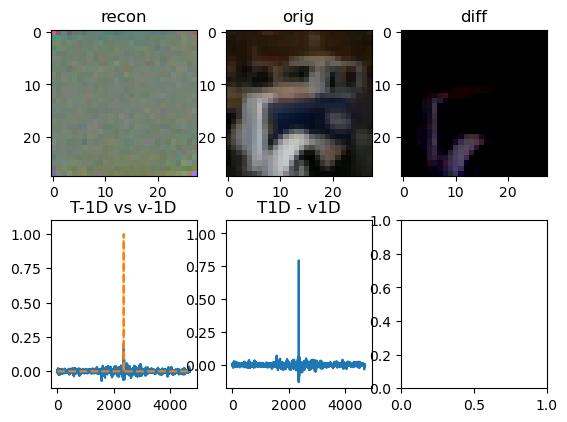

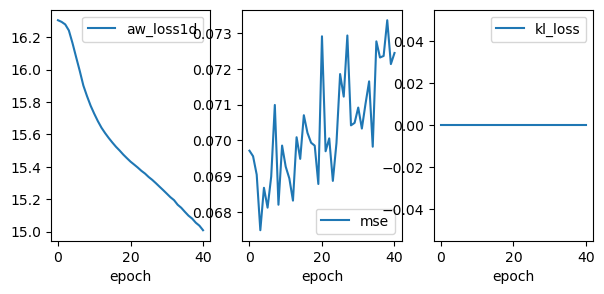

 60% (60 of 100) |#############          | Elapsed Time: 0:09:12 ETA:   0:06:09


 {'epoch': 60, 'train_mse': 0.07244650274515152, 'train_awi1d_loss': 14.58448600769043, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


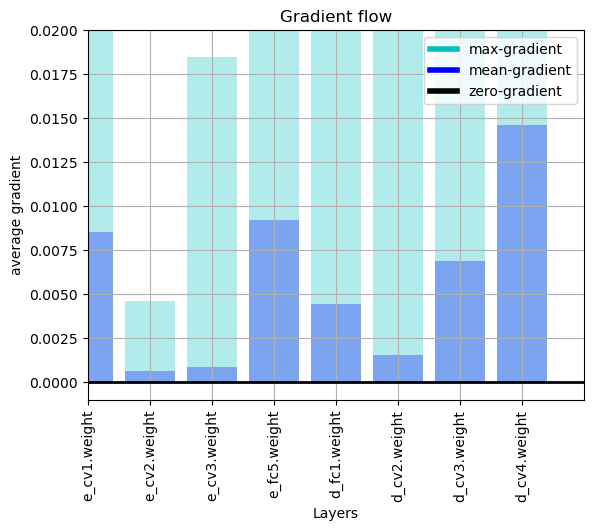

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


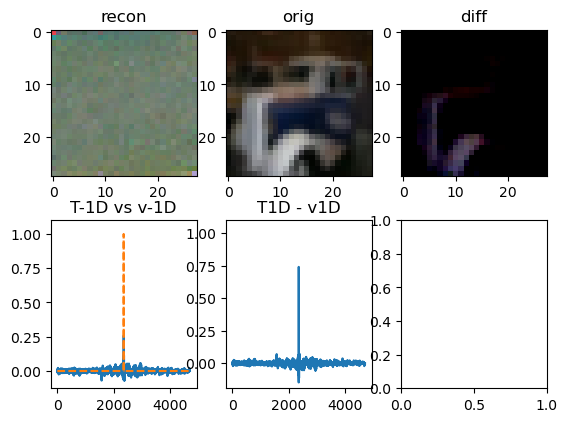

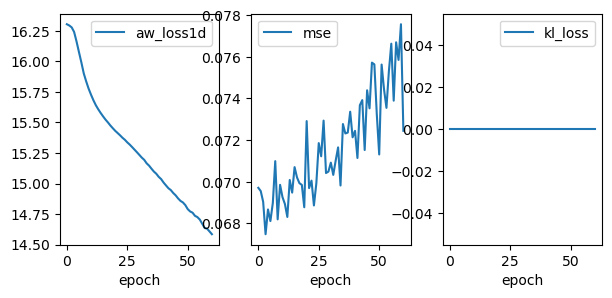

 80% (80 of 100) |##################     | Elapsed Time: 0:12:17 ETA:   0:03:03


 {'epoch': 80, 'train_mse': 0.07821252942085266, 'train_awi1d_loss': 13.999557495117188, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


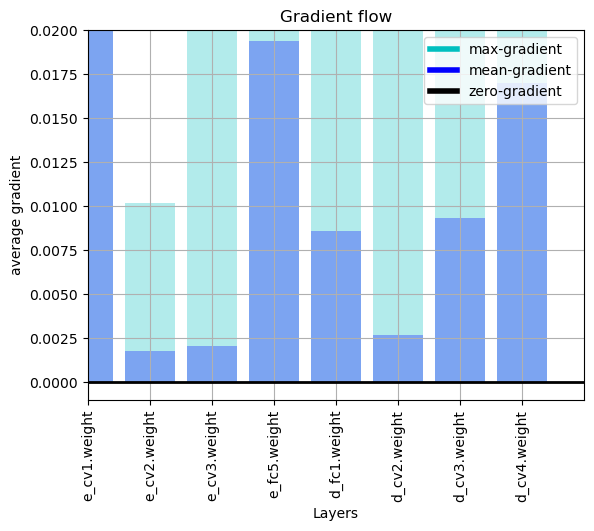

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


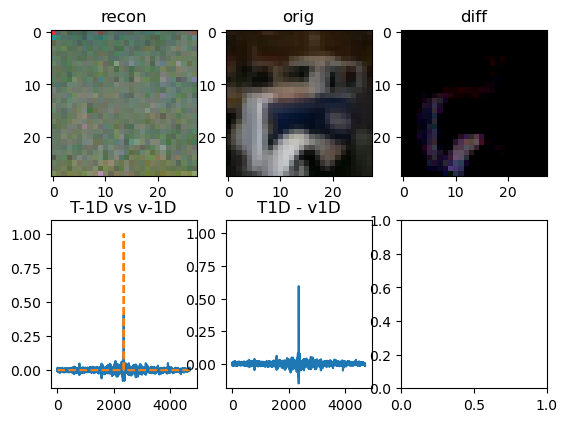

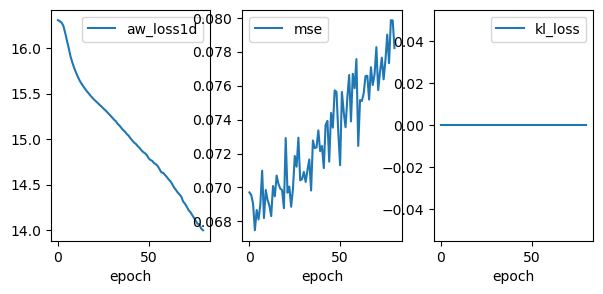

 99% (99 of 100) |###################### | Elapsed Time: 0:15:13 ETA:   0:00:09


 {'epoch': 99, 'train_mse': 0.08060825616121292, 'train_awi1d_loss': 13.363462448120117, 'train_kl_loss': 0.0}
 argidx T, v:  2351 2351


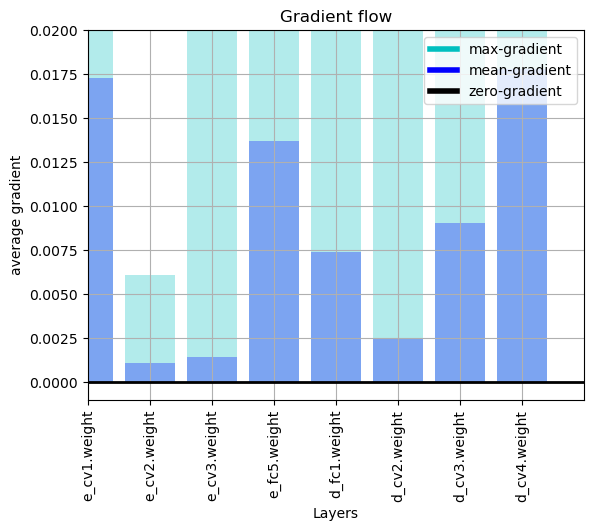

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


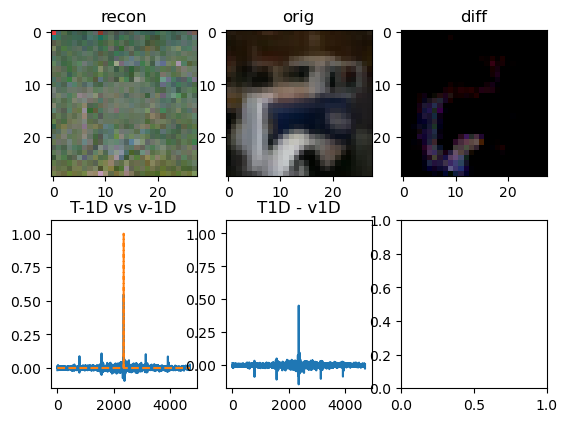

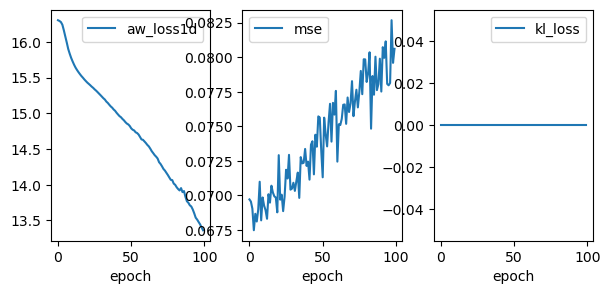

100% (100 of 100) |######################| Elapsed Time: 0:15:14 Time:  0:15:14


In [5]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06914792209863663, 'train_awi1d_loss': 16.300704956054688, 'train_kl_loss': 439.41375732421875}
 argidx T, v:  2351 2351


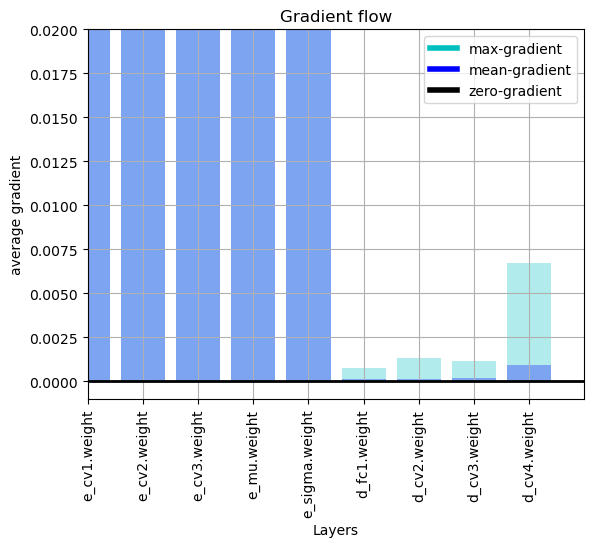

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


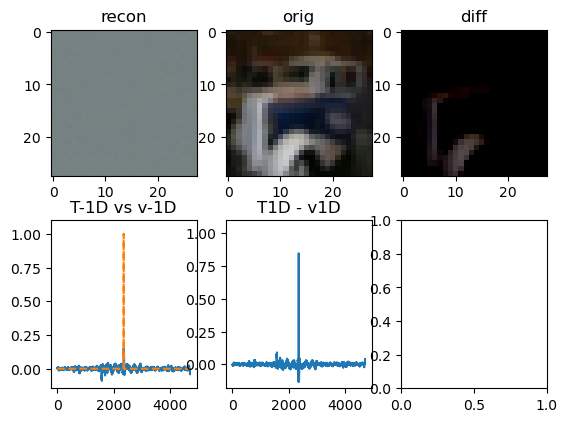

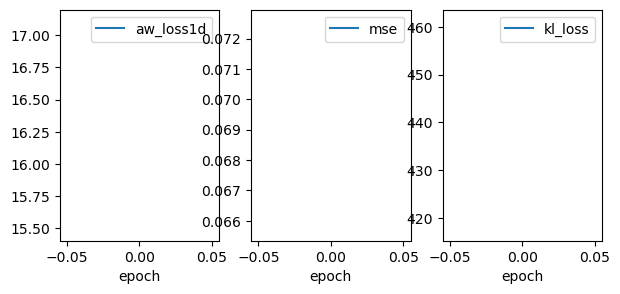

 20% (20 of 100) |####                   | Elapsed Time: 0:03:03 ETA:   0:12:11


 {'epoch': 20, 'train_mse': 0.068627268075943, 'train_awi1d_loss': 15.846802711486816, 'train_kl_loss': 432.0352478027344}
 argidx T, v:  2351 2351


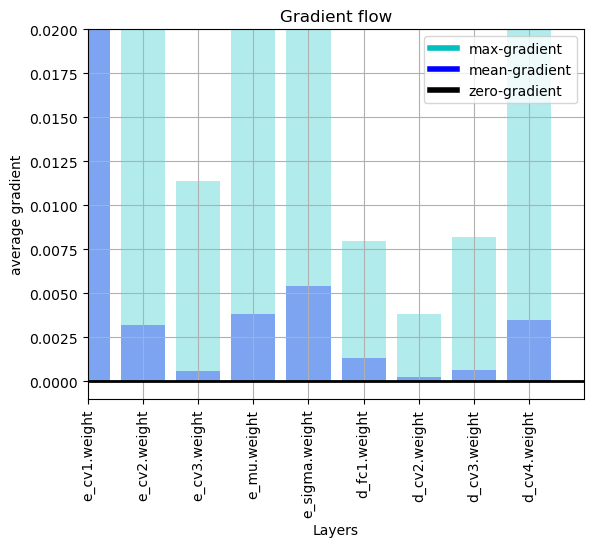

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


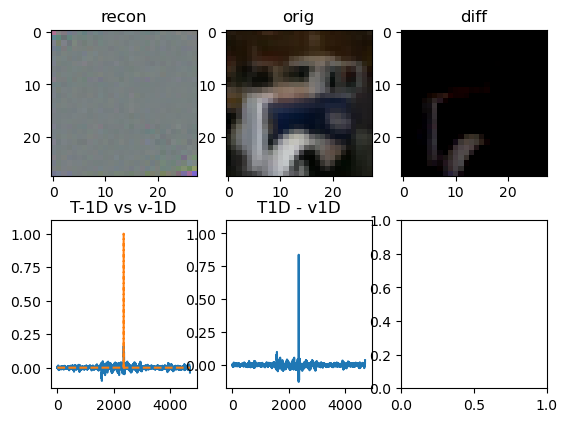

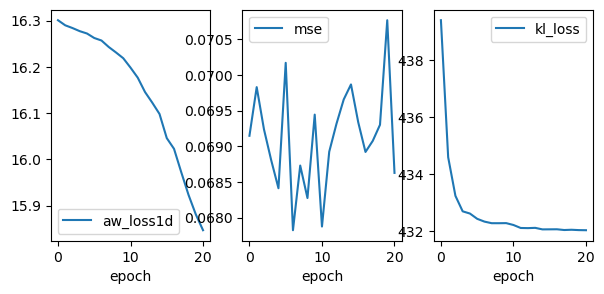

 40% (40 of 100) |#########              | Elapsed Time: 0:06:08 ETA:   0:09:12


 {'epoch': 40, 'train_mse': 0.07153767347335815, 'train_awi1d_loss': 15.43011474609375, 'train_kl_loss': 432.0071716308594}
 argidx T, v:  2351 2351


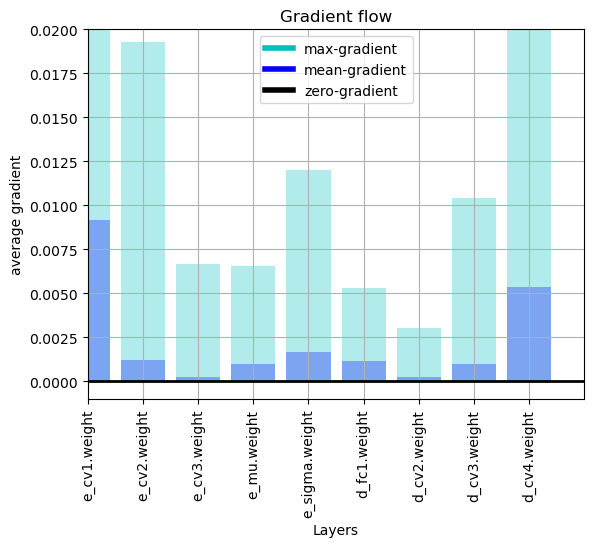

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


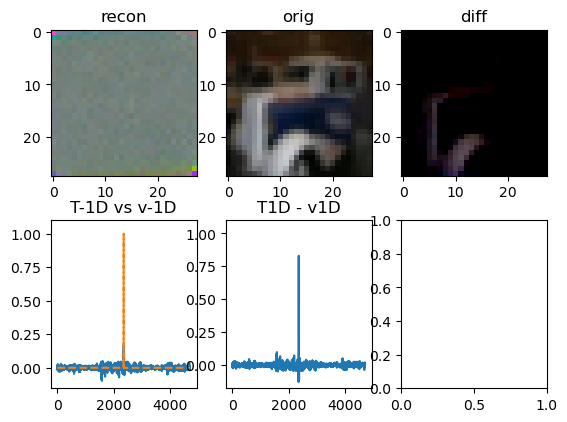

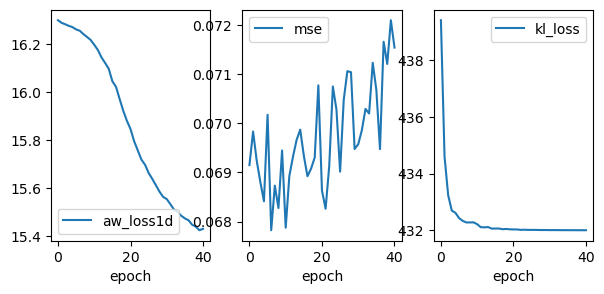

 60% (60 of 100) |#############          | Elapsed Time: 0:09:19 ETA:   0:06:08


 {'epoch': 60, 'train_mse': 0.07136163115501404, 'train_awi1d_loss': 15.273309707641602, 'train_kl_loss': 432.00408935546875}
 argidx T, v:  2351 2351


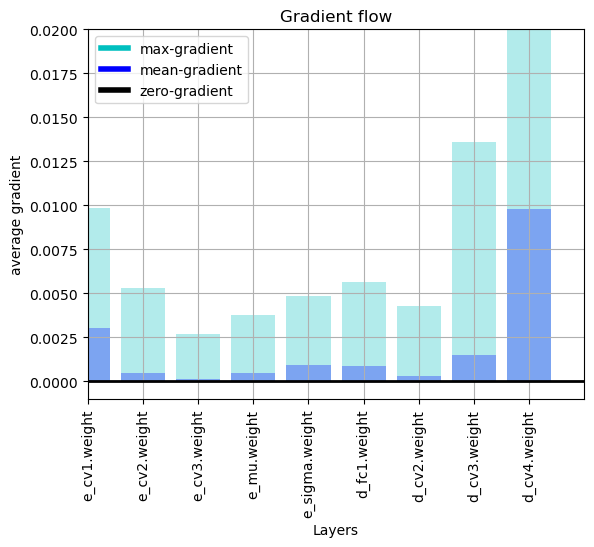

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


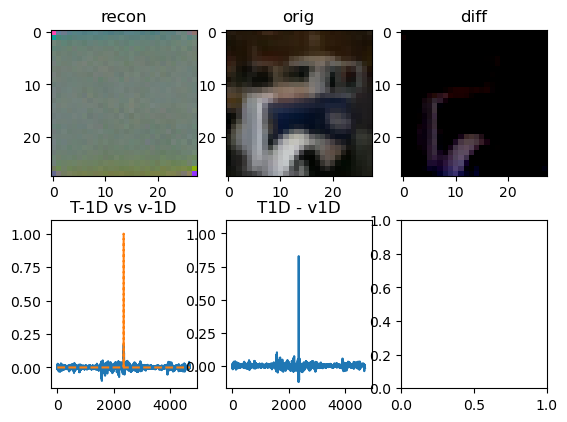

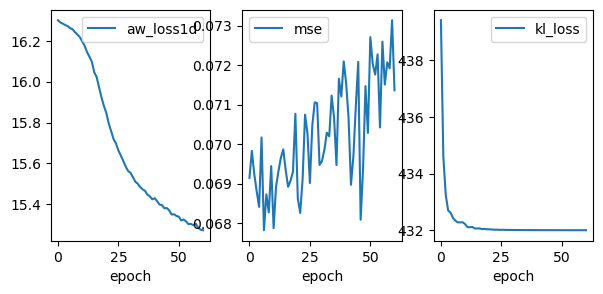

 80% (80 of 100) |##################     | Elapsed Time: 0:12:35 ETA:   0:03:07


 {'epoch': 80, 'train_mse': 0.07305130362510681, 'train_awi1d_loss': 15.227714538574219, 'train_kl_loss': 432.0027160644531}
 argidx T, v:  2351 2351


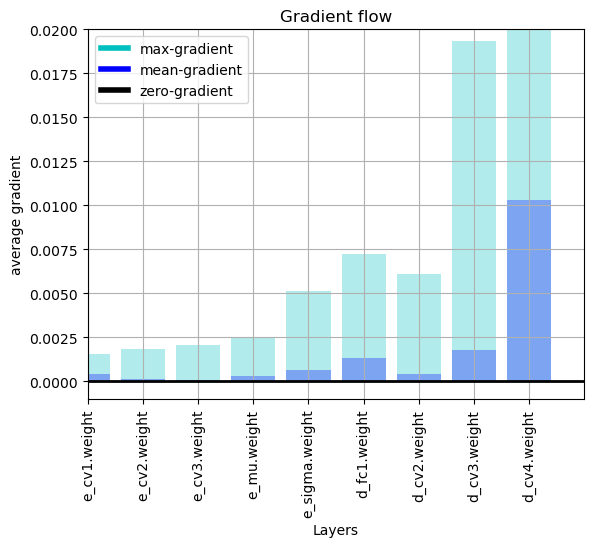

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


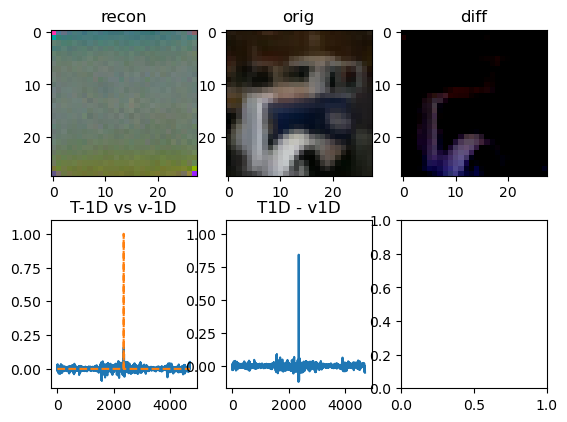

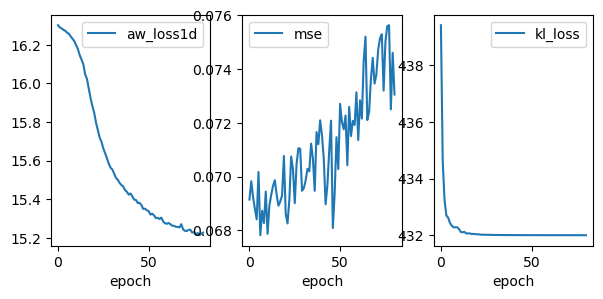

 99% (99 of 100) |###################### | Elapsed Time: 0:15:39 ETA:   0:00:09


 {'epoch': 99, 'train_mse': 0.07872194051742554, 'train_awi1d_loss': 15.181424140930176, 'train_kl_loss': 432.00189208984375}
 argidx T, v:  2351 2351


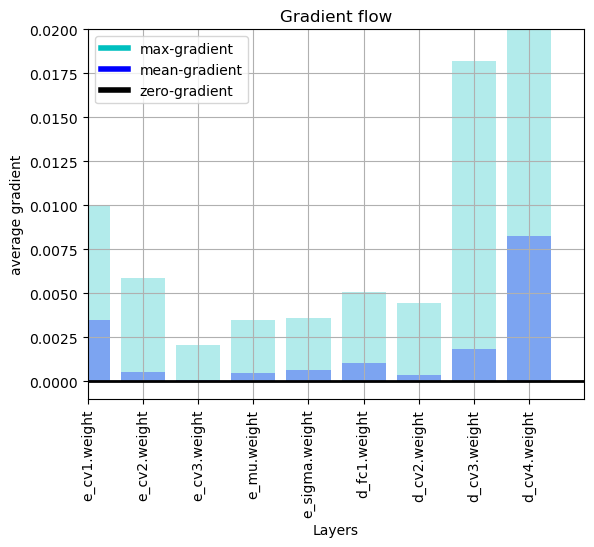

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


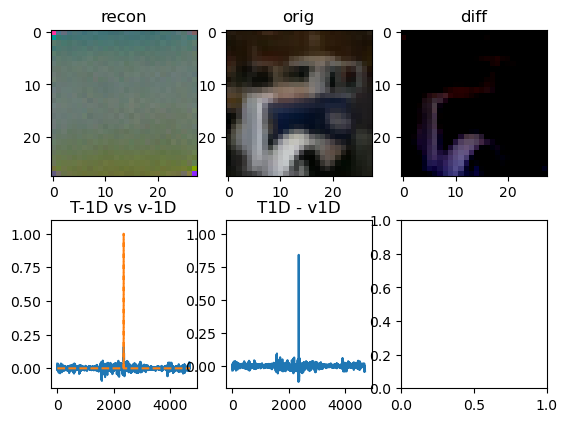

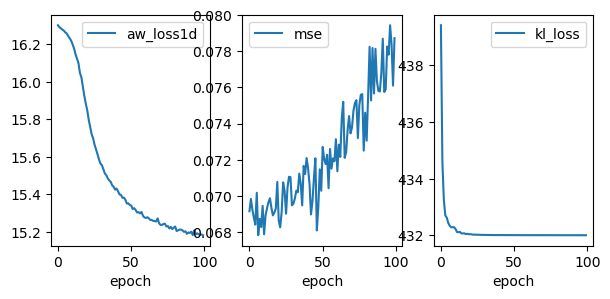

100% (100 of 100) |######################| Elapsed Time: 0:15:39 Time:  0:15:39


In [6]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)